In [1]:
#Load Libraries
import gensim
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from statistics import mean


# Surpress any warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import string


course_genre_df = pd.read_csv('course_genre.csv')
sim_df = pd.read_csv('sim.csv')

In [2]:
def compute_silhouette_score(courses, sim_scores):
    avg_sim_scores = []
    for i in enumerate(courses):
        avg_sim_scores.append(np.mean(sim_scores[i]))
    silhouette_scores = []
    for i in enumerate(courses):
        diff = []
        for j, other_course in enumerate(courses):
            if i != j:
                diff.append(abs(avg_sim_scores[i] - avg_sim_scores[j]))
        silhouette_scores.append(max(diff) / (avg_sim_scores[i] + np.min(diff)))

    return np.mean(silhouette_scores)

In [3]:
def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix):
    # Create a dictionary to store your recommendation results
    res = {}
    threshold = 0.6 
    for enrolled_course in enrolled_course_ids:
        for unselect_course in unselected_course_ids:
            if enrolled_course in id_idx_dict and unselect_course in id_idx_dict:
                
                # Find the two indices for each enrolled_course and unselect_course, based on their two ids
                enrolled_course_idx = id_idx_dict[enrolled_course]
                unselect_course_idx = id_idx_dict[unselect_course]
                
                # Calculate the similarity between an enrolled_course and an unselect_course
                # Find the similarity value from the sim_matrix
                sim = sim_matrix[enrolled_course_idx][unselect_course_idx]
                
                if sim > threshold:
                    if unselect_course not in res:
                        res[unselect_course] = sim
                    else:
                        if sim >= res[unselect_course]:
                            res[unselect_course] = sim
                            
    # Sort the results by similarity
    res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
    return res

In [4]:
def generate_recommendations_for_all():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    test_users_df = pd.read_csv('rs_content_test.csv')
    # Course similarity matrix
    sim_df = pd.read_csv('sim.csv')
    # Course content dataframe
    course_df = pd.read_csv('course_genre.csv') #change to course_genres_df
    # Course BoW features
    bow_df = pd.read_csv('courses_bows.csv') # change to the one that you made
    test_users = test_users_df.groupby(['user']).max()
    test_user_ids = test_users['user'].to_list()
    
    for user_id in test_user_ids:
        users.append(user_id)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        # Extract the enrolled courses for the current user
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].tolist()
        # Extract the unselected courses for the current user
        unselected_courses = list(set(course_df['COURSE_ID']) - set(enrolled_courses))
        # Create the id_idx_dict dictionary
        id_idx_dict = {course_df.iloc[i]['COURSE_ID']: i for i in range(course_df.shape[0])}
        # Create the sim_matrix list of lists
        sim_matrix = sim_df.values.tolist()
        
        recommendations = generate_recommendations_for_one_user(enrolled_courses, unselected_courses, id_idx_dict, sim_matrix)
        recommended_courses = list(recommendations.keys())
        recommended_scores = list(recommendations.values())
        courses.append(recommended_courses)
        sim_scores.append(recommended_scores)
    
    return users, courses, sim_scores


In [5]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])

In [6]:
res_df

,USER,COURSE_ID,SCORE
0,37465,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
1,50348,"[CB0101EN, DS0110EN, CL0101EN, excourse67, exc...","[0.9233805168766388, 0.7329409123199365, 0.732..."
2,52091,"[ML0120ENv3, CB0101EN, excourse24, excourse36,...","[1.0, 0.9233805168766388, 0.7526312050490548, ..."
3,70434,"[excourse67, excourse72, excourse74, excourse68]","[0.7082138557765277, 0.7036476305124202, 0.650..."
4,85625,"[TMP0101EN, excourse72, TA0105EN, BD0151EN, BD...","[0.8894991799933215, 0.7036476305124202, 0.659..."
...,...,...,...
995,2061096,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
996,2074313,"[excourse36, excourse23, DS0110EN, DV0151EN, e...","[0.7397041774816828, 0.7397041774816828, 0.732..."
997,2074462,"[CL0101EN, excourse62, excourse22, excourse24]","[0.7327907262791404, 0.6475015976638527, 0.647..."
998,2082818,"[DV0151EN, ML0115EN, ML0122EN]","[0.7235359517703827, 0.7071067811865475, 0.681..."


In [7]:
def get_most_common_item_and_score(res_df):
    altered_hyperparam = {}
    
    course_elements = []
    course_frequency = []
    percentage_course_occurences = []
    score_elements = []
    score_frquency = []
    
    COURSE_ID_res_col = res_df.iloc[:,1]
    COURSE_ID_res_list =  COURSE_ID_res_col.tolist()
    COURSE_ID_res_list_unpacked = [item for sublist in COURSE_ID_res_list for item in sublist]
    course_counts = Counter(COURSE_ID_res_list_unpacked)
    top_10_course_counts = course_counts.most_common(10)
    for element, frequency in top_10_course_counts:
        course_elements.append(element)
        course_frequency.append(frequency)
    
    for frequency in course_frequency:
        percentage_course_occurences.append(frequency/(len(COURSE_ID_res_list_unpacked)))
    
    SCORE_res_col = res_df.iloc[:,2]
    SCORE_res_col = res_df.iloc[:,2]
    SCORE_res_list =  SCORE_res_col.tolist()
    SCORE_res_list_unpacked = [item for sublist in SCORE_res_list for item in sublist]
    score_counts = Counter(SCORE_res_list_unpacked)
    top_10_course_counts = score_counts.most_common(10)
    for element, frequency in top_10_course_counts:
        score_elements.append(element)
        score_frquency.append(frequency)
    
    results_dictionary = {'top_10_most_common_courses': [course_elements],
                         'frequency_of_common_courses': [course_frequency],
                         'percentage_of_course_occurences': [percentage_course_occurences],
                         'top_10_most_common_scores': [score_elements],
                         'frequency_of_most_common_scores': [score_frquency],
                         'mean_of_score': [mean(score_elements)]}

    
    return results_dictionary


In [8]:
original_sim_and_bow_stats = get_most_common_item_and_score(res_df)



In [ ]:
# Change hyper param: Generate own Similarity matrix
course_genre_values = course_genre_df.iloc[:,2:].values
similarity_matrix = np.dot(course_genre_values, course_genre_values.T)

# Create a list of column names
columns = [str(i) for i in range(307)]

# Create a list of row names
row_names = [str(i) for i in range(307)]

# Create the dataframe
generated_sim_df = pd.DataFrame(similarity_matrix, index=row_names, columns=columns)
generated_sim_df
silhouette_score_0 = compute_silhouette_score(courses, sim_scores)

In [10]:
def generate_recommendations_for_all_with_sim_df():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    test_users_df = pd.read_csv('rs_content_test.csv')
    # Course similarity matrix
    sim_df = generated_sim_df
    # Course content dataframe
    course_df = pd.read_csv('course_genre.csv') #change to course_genres_df
    # Course BoW features
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    
    for user_id in test_user_ids:
        users.append(user_id)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        # Extract the enrolled courses for the current user
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].tolist()
        # Extract the unselected courses for the current user
        unselected_courses = list(set(course_df['COURSE_ID']) - set(enrolled_courses))
        # Create the id_idx_dict dictionary
        id_idx_dict = {course_df.iloc[i]['COURSE_ID']: i for i in range(course_df.shape[0])}
        # Create the sim_matrix list of lists
        sim_matrix = sim_df.values.tolist()
        
        recommendations = generate_recommendations_for_one_user(enrolled_courses, unselected_courses, id_idx_dict, sim_matrix)
        recommended_courses = list(recommendations.keys())
        recommended_scores = list(recommendations.values())
        courses.append(recommended_courses)
        sim_scores.append(recommended_scores)
    
    return users, courses, sim_scores


In [11]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all_with_sim_df()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
generated_sim_matrix_stats = get_most_common_item_and_score(res_df)
silhouette_score_1 = compute_silhouette_score(courses, sim_scores)

In [12]:
import gensim
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.corpora import Dictionary
course_content_df= pd.read_csv('course_processed.csv')
# Use stopwords provided in nltk
stop_words = set(stopwords.words('english'))

# Merge TITLE and DESCRIPTION title
course_content_df['course_texts'] = course_content_df[['TITLE', 'DESCRIPTION']].agg(' '.join, axis=1)

# Convert course content into list of strings
courses_prelist = course_content_df['course_texts']

# Convert the courses column to a list of strings
courses_new_2 = courses_prelist.astype(str).tolist()

#Define tokenize courses function
def tokenize_courses(courses, keep_only_nouns=True):
    
    stop_words = set(stopwords.words('english'))
    tokenized_courses = []
    for course in courses:
        word_tokens = word_tokenize(course)
        # Remove English stop words and numbers
        word_tokens = [w for w in word_tokens if (not w.lower() in stop_words) and (not w.isnumeric())]
        # Only keep nouns 
        if keep_only_nouns:
            filter_list = ['WDT', 'WP', 'WRB', 'FW', 'IN', 'JJR', 'JJS', 'MD', 'PDT', 'POS', 'PRP', 'RB', 'RBR', 'RBS',
                           'RP']
            tags = nltk.pos_tag(word_tokens)
            word_tokens = [word for word, pos in tags if pos not in filter_list]
        tokenized_courses.append(word_tokens)
    return tokenized_courses

# Use the tokenized function and get the tokenized words
tokenized_courses_new = tokenize_courses(courses = courses_new_2, keep_only_nouns=True)

#Token of dictionary
token_dictionary = Dictionary(tokenized_courses_new)

# Convert each tokenized course into a bag-of-words representation
bow_features = [token_dictionary.doc2bow(course) for course in tokenized_courses_new]


# Create lists to hold the doc index, doc ID, token, and BoW value for each feature
doc_indices = []
doc_ids = []
tokens = []
bow_values = []

# Iterate over the bow_features list
for index, feature in enumerate(bow_features):
    doc_index = index  # Extract the doc index, doc ID, and BoW value for each feature
    doc_id = course_content_df['COURSE_ID'][index]
    for token_id, value in feature:
        doc_indices.append(doc_index)
        doc_ids.append(doc_id)
        tokens.append(token_dictionary.get(token_id))
        bow_values.append(value)

# Create a dataframe with the features data
bows_df = pd.DataFrame({'COURSE_ID': doc_ids, 'TOKEN': tokens, 'COUNT': bow_values},
                      index=doc_indices)



In [13]:
def generate_recommendations_for_all_with_bows_df():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    test_users_df = pd.read_csv('rs_content_test.csv')
    # Course similarity matrix
    sim_df = generated_sim_df
    # Course content dataframe
    course_df = pd.read_csv('course_genre.csv') #change to course_genres_df
    # Course BoW features
    bow_df = bows_df # change to the one that you made
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    
    for user_id in test_user_ids:
        users.append(user_id)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        # Extract the enrolled courses for the current user
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].tolist()
        # Extract the unselected courses for the current user
        unselected_courses = list(set(course_df['COURSE_ID']) - set(enrolled_courses))
        # Create the id_idx_dict dictionary
        id_idx_dict = {course_df.iloc[i]['COURSE_ID']: i for i in range(course_df.shape[0])}
        # Create the sim_matrix list of lists
        sim_matrix = sim_df.values.tolist()
        
        recommendations = generate_recommendations_for_one_user(enrolled_courses, unselected_courses, id_idx_dict, sim_matrix)
        recommended_courses = list(recommendations.keys())
        recommended_scores = list(recommendations.values())
        courses.append(recommended_courses)
        sim_scores.append(recommended_scores)
    
    return users, courses, sim_scores


In [14]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all_with_bows_df()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
generated_bows_and_sim_matrix_stats = get_most_common_item_and_score(res_df)
silhouette_score_2 = compute_silhouette_score(courses, sim_scores)

In [15]:
def generate_recommendations_for_all_with_bows_df_old_sim():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    test_users_df = pd.read_csv('rs_content_test.csv')
    # Course similarity matrix
    sim_df = pd.read_csv('sim.csv')
    # Course content dataframe
    course_df = pd.read_csv('course_genre.csv') #change to course_genres_df
    # Course BoW features
    bow_df = bows_df # change to the one that you made
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    
    for user_id in test_user_ids:
        users.append(user_id)
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        # Extract the enrolled courses for the current user
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].tolist()
        # Extract the unselected courses for the current user
        unselected_courses = list(set(course_df['COURSE_ID']) - set(enrolled_courses))
        # Create the id_idx_dict dictionary
        id_idx_dict = {course_df.iloc[i]['COURSE_ID']: i for i in range(course_df.shape[0])}
        # Create the sim_matrix list of lists
        sim_matrix = sim_df.values.tolist()
        
        recommendations = generate_recommendations_for_one_user(enrolled_courses, unselected_courses, id_idx_dict, sim_matrix)
        recommended_courses = list(recommendations.keys())
        recommended_scores = list(recommendations.values())
        courses.append(recommended_courses)
        sim_scores.append(recommended_scores)
    
    return users, courses, sim_scores


In [ ]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all_with_bows_df_old_sim()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
generated_bows_matrix_stats = get_most_common_item_and_score(res_df)
silhouette_score_3 = compute_silhouette_score(courses, sim_scores)

In [17]:
stats_list = [generated_bows_matrix_stats, generated_bows_and_sim_matrix_stats, generated_sim_matrix_stats, original_sim_and_bow_stats]
stats_list_names = ["1", "2", "3", "4"]

              

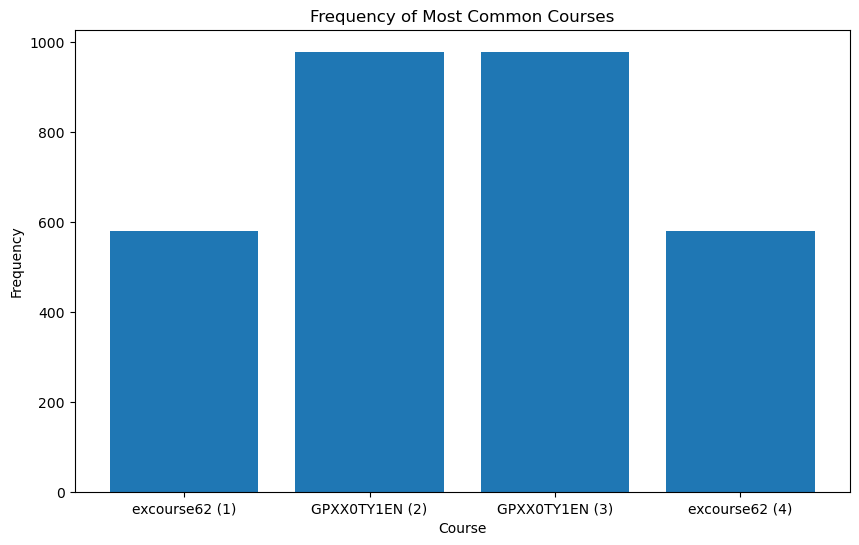

In [18]:
import matplotlib.pyplot as plt

# Extract the top 10 most common courses and their frequency from each dictionary in the list
top_10_courses = [d['top_10_most_common_courses'][0] for d in stats_list]
course_frequency = [d['frequency_of_common_courses'][0] for d in stats_list]

most_common_course = []
frequency_of_reccomendations = []
for course in top_10_courses:
    most_common_course.append(course[0])
    
for course in course_frequency:
    frequency_of_reccomendations.append(course[0])

most_common_course_2 = []
for x, y in zip(most_common_course, stats_list_names):
    most_common_course_2.append(f"{x} ({y})")
    

# Set the x-axis values to be the top 10 courses
x = most_common_course

# Set the y-axis values to be the frequency of each course
y = frequency_of_reccomendations

# Set the labels for the x-axis
x_labels = pd.Series(most_common_course_2)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the data as a bar chart
plt.bar(x_labels, y)

# Set the title and labels for the plot
plt.title("Frequency of Most Common Courses")
plt.xlabel("Course")
plt.ylabel("Frequency")

# Show the plot
plt.show()


In [19]:
top_10_courses = [d['top_10_most_common_courses'][0] for d in stats_list]
course_frequency = [d['frequency_of_common_courses'][0] for d in stats_list]

In [20]:
percentage_of_course_occurences = [d['percentage_of_course_occurences'][0] for d in stats_list]
top_10_most_common_scores = [d['top_10_most_common_scores'][0] for d in stats_list]
frequency_of_most_common_scores = [d['frequency_of_most_common_scores'][0] for d in stats_list]
mean_of_score = [d['mean_of_score'][0] for d in stats_list]

percentage_of_course_occurences

for x, y in zip(most_common_course, stats_list_names):
    most_common_course_2.append(f"{x} ({y})")

In [21]:
model_1_course = top_10_courses[0]
model_2_course = top_10_courses[1]
model_3_course = top_10_courses[3]

In [22]:
model_1_freq = course_frequency[0]
model_2_freq = course_frequency[1]
model_3_freq = course_frequency[3]


In [23]:
df_results_1 = pd.DataFrame({'top_courses': model_1_course, 'Frequency of reccomendation': model_1_freq})
df_results_2 = pd.DataFrame({'top_courses': model_2_course, 'Frequency of reccomendation': model_2_freq})
df_results_3 = pd.DataFrame({'top_courses': model_3_course, 'Frequency of reccomendation': model_3_freq})


In [24]:
df_results_1

,top_courses,Frequency of reccomendation
0,excourse62,579
1,excourse22,579
2,DS0110EN,562
3,excourse63,555
4,excourse65,555
5,excourse72,551
6,excourse68,550
7,excourse67,539
8,excourse74,539
9,BD0145EN,506


In [25]:
df_results_2

,top_courses,Frequency of reccomendation
0,GPXX0TY1EN,978
1,excourse04,952
2,excourse06,952
3,GPXX0IBEN,944
4,TA0106EN,942
5,excourse12,941
6,GPXX0D14EN,933
7,excourse65,919
8,GPXX0PG8EN,919
9,GPXX0KY1EN,919


In [26]:
df_results_3

,top_courses,Frequency of reccomendation
0,excourse62,579
1,excourse22,579
2,DS0110EN,562
3,excourse63,555
4,excourse65,555
5,excourse72,551
6,excourse68,550
7,excourse67,539
8,excourse74,539
9,BD0145EN,506


[]

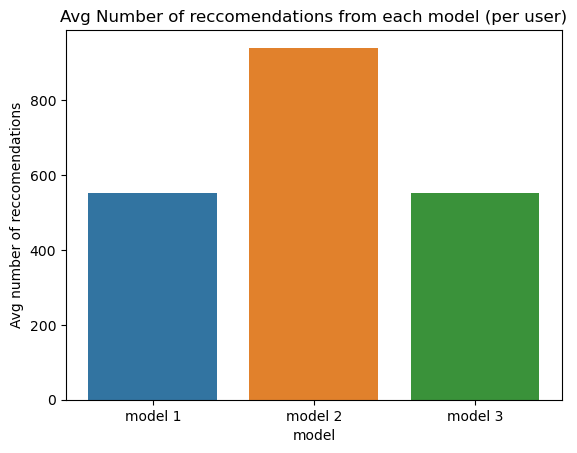

In [27]:
df_list = [df_results_1, df_results_2, df_results_3]
df_list_names = ['model 1', 'model 2', 'model 3']

# # Sort the dataframe by the 'size' column in descending order
# sorted_courses = course_counts.sort_values(by='Frequency of reccomendation', ascending=False)
# #Reset index
# sorted_courses = sorted_courses.reset_index(drop=True)

means = []
for x in df_list:
    means.append(x['Frequency of reccomendation'].mean())

import matplotlib.pyplot as plt
import seaborn as sns
# create a dataframe with the values and names
df_results_final = pd.DataFrame({'Avg number of reccomendations': means, 'model': df_list_names})

# use seaborn to plot the bar chart
sns.barplot(x='model', y='Avg number of reccomendations', data=df_results_final)
plt.title('Avg Number of reccomendations from each model (per user)')
plt.plot()

In [42]:
silhoette_score_list = [silhouette_score_1, silhouette_score_2, silhouette_score_3]

[]

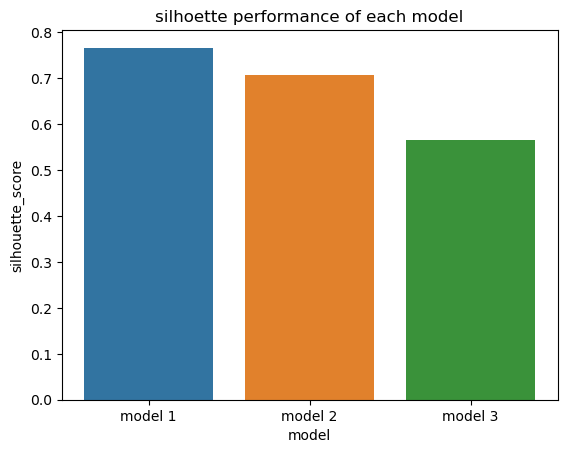

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
# create a dataframe with the values and names
df_sil = pd.DataFrame({'silhouette_score': silhoette_score_list, 'model': df_list_names})

# use seaborn to plot the bar chart
sns.barplot(x='model', y='silhouette_score', data=df_sil)
plt.title('silhoette performance of each model')
plt.plot()

In [45]:
df_results_1

,top_courses,Frequency of reccomendation
0,excourse62,579
1,excourse22,579
2,DS0110EN,562
3,excourse63,555
4,excourse65,555
5,excourse72,551
6,excourse68,550
7,excourse67,539
8,excourse74,539
9,BD0145EN,506


In [50]:
merged_df = pd.merge(df_results_1, course_genres_df, left_on='top_courses', right_on='COURSE_ID')

In [49]:
course_genres_df = pd.read_csv('course_genre.csv')

In [55]:
merged_df.loc[:,['TITLE', 'Frequency of reccomendation']]

,TITLE,Frequency of reccomendation
0,introduction to data science in python,579
1,introduction to data science in python,579
2,data science with open data,562
3,a crash course in data science,555
4,data science fundamentals for data analysts,555
5,foundations for big data analysis with sql,551
6,big data modeling and management systems,550
7,introduction to big data,539
8,fundamentals of big data,539
9,sql access for hadoop,506
